
Developed by huggingface, the library transformers offer easy-to-use APIs for downloading and training top pre-trained models, reducing compute costs, carbon footprint, and saving time and resources. These models facilitate various tasks across modalities:

1. Natural Language Processing: Includes tasks like text classification, entity recognition, question answering, summarization, translation, and more.

2. Computer Vision: Covers image classification, object detection, segmentation.

3. Audio: Features automatic speech recognition and classification.

4. Multimodal: Handles tasks like table QA, OCR, document analysis, video classification, and visual QA."

And transformers support framework interoperability between PyTorch, Tensorflow, and JAX. In the following tutorial, we will be focused on NLP tasks.

In [ ]:
# install the library
!pip install transformers[torch] datasets -q

## Part 1: Use Pipeline

Pipeline is the simplest and quickest way to apply NLP models provided by huggingface. To run the inference, it has the following steps:

1. Define the name of a task (The full list is [here](https://huggingface.co/tasks))

2. Create the pipeline object (a suitable model is downloaded automatically from the model repo)

3. Feed the data to the object

In [ ]:
# sentiment analysis
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
res = classifier("I am a huge fan of Naruto")
print(f"{res[0]['label']} with score {res[0]['score']}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

POSITIVE with score 0.9994252920150757


The model output is a list of dictionaries, where each dictionary has a label (for this specific example, with values “POSITIVE” or “NEGATIVE”) and a score (i.e. the score of the predicted label).

In [ ]:
# You can pass multiple sentences
results = classifier(["I am a huge fan of Naruto", "I hope you don't hate Naruto..."])
for result in results:
    print(f"{result['label']} with score {result['score']}")

POSITIVE with score 0.9994252920150757
NEGATIVE with score 0.7557418942451477


You can specifiy a different model in the pipeline. Two arguments could be specified:
1. Model
2. Tokenizer

For example, you can go to one of the model page that you are interested at.  
Here, we can use
[twitter-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)


In [ ]:
classifier = pipeline("sentiment-analysis",
                      model="cardiffnlp/twitter-roberta-base-sentiment",
                      tokenizer="cardiffnlp/twitter-roberta-base-sentiment")
res = classifier("I am a huge fan of Naruto🤗.")
print(f"{res[0]['label']} with score {res[0]['score']}")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

LABEL_2 with score 0.9603255391120911


## Part 2: Cracking open the NLP Pipeline modeling

The pipeline has three modules in sequence including:
1. Tokenizer: convert raw text into the sequence of token id
2. Model: perform prediction
3. Post Processing: convert prediction into human-friendly results

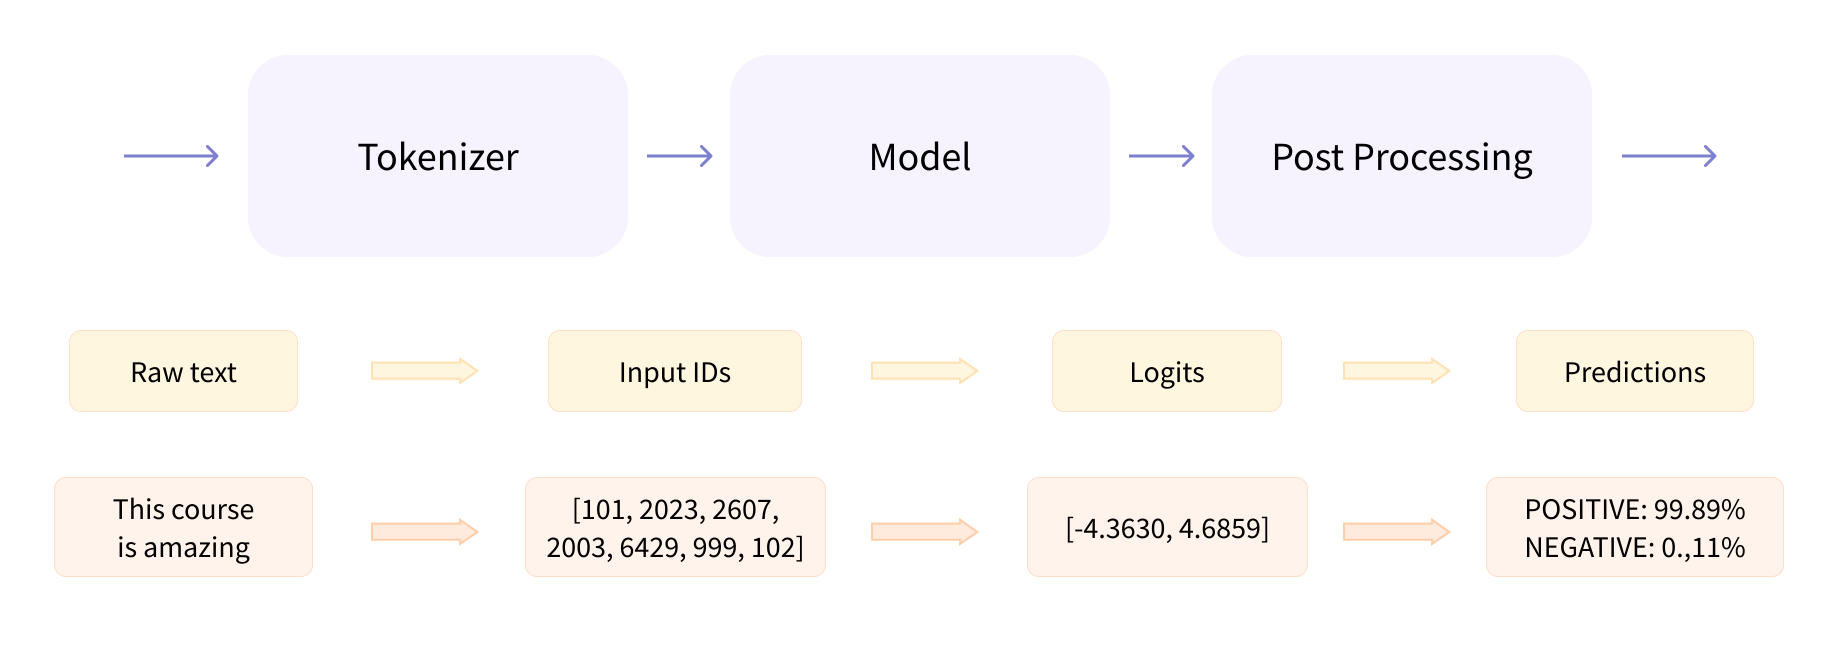



## Use AutoClasses

Under the hood, the pipeline is powered by AutoModel and AutoTokenizer classes. An AutoClass (i.e. a general class like AutoModel and AutoTokenizer) is a shortcut that automatically retrieves the architecture of a pre-trained model (or tokenizer) from its name or path. You only need to select the appropriate AutoModel for your task and its associated tokenizer with AutoTokenizer: in our example, since we are classifying text, the correct AutoModel is AutoModelForSequenceClassification.

Firstly, a tokenizer is created.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import nn
import torch
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

We create a tokenizer object using the AutoTokenizer and a model object using the AutoModelForSequenceClassification. In both cases, all we need to do is to pass the name of the model, and the library manages everything else.

In [ ]:
encoding = tokenizer(["I am a huge fan of Naruto","I love this movie"], padding=True,
                     truncation=True, max_length=10, return_tensors="pt")
print(encoding)
print(encoding['attention_mask'])

{'input_ids': tensor([[  101,   151, 10345,   143, 37985, 10923, 10108, 48458,   102],
        [  101,   151, 11157, 10372, 13113,   102,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0]])}
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0]])


The tokenizer output is a dictionary composed of
1. input_ids (i.e. the id of each token detected in the input sentences, taken from the tokenizer vocabulary)
2. token_type_ids (used in models where two texts are needed for predictions, we can ignore them for now)
3. attention_mask (showing where padding occurred during tokenization).

The tokenized sentences are then passed to the model, which outputs the predictions. This specific model outputs five scores, where each score is the probability of a human review with a score from one to five.

In [ ]:
outputs = model(**encoding)
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5649, -1.5191, -0.5190,  0.9009,  2.0663],
        [-2.3014, -2.5189, -0.8391,  1.3374,  3.5001]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [ ]:
pt_predictions = nn.functional.softmax(outputs.logits, dim=-1)
print(pt_predictions)
"""
tensor([[0.1210, 0.0619, 0.1110, 0.1470, 0.5592],
       [0.1269, 0.0945, 0.1168, 0.1902, 0.4716]], grad_fn=<SoftmaxBackward0>)
"""

tensor([[0.0184, 0.0192, 0.0523, 0.2163, 0.6938],
        [0.0027, 0.0021, 0.0115, 0.1015, 0.8822]], grad_fn=<SoftmaxBackward0>)


'\ntensor([[0.1210, 0.0619, 0.1110, 0.1470, 0.5592],\n       [0.1269, 0.0945, 0.1168, 0.1902, 0.4716]], grad_fn=<SoftmaxBackward0>)\n'

## Part 3: Dataset

With the dataset library we can easily download some of the most common benchmarks used in NLP.

Let’s try loading the Stanford Sentiment Treebank (SST2), which consists of sentences from movie reviews and human annotations of their sentiment. It uses the two-way (positive and negative) class split, with only sentence-level labels. We can find the SST2 dataset under the datasets library, stored as a subset of the GLUE dataset. We load the dataset using the load_dataset function.

In [ ]:
import datasets

dataset = datasets.load_dataset("glue", "sst2")
print(dataset)

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


Let’s try loading the Stanford Sentiment Treebank (SST2), which consists of sentences from movie reviews and human annotations of their sentiment. It uses the two-way (positive and negative) class split, with only sentence-level labels. We can find the SST2 dataset under the datasets library, stored as a subset of the GLUE dataset. We load the dataset using the load_dataset function.

In [ ]:

import pandas as pd


dataset = datasets.load_dataset("glue", "sst2", split='train')
print(dataset)
"""
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})
"""

df = pd.DataFrame(dataset)
df.head()

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})


,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


## Part 4: Finetuning

Transformers also allow us to update those pretrained models on a dataset specific to your need that is called as fine-tuning. In this part, we'll guide you through fine-tuning a pretrained model using Transormers Trainer. Beside this, fine-tuning could also be done in tensorflow with keras and native PyTorch.

In [ ]:
# Check the performances of the pre-trained models
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import nn
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
train_texts = ["This is a great notebook", "I hate this film"]

In [ ]:
train_encodings = tokenizer(train_texts, return_tensors="pt", padding=True, truncation=True)

In [ ]:
outputs = model(**train_encodings)
pretrained_predictions = nn.functional.softmax(outputs.logits, dim=-1)
print(pretrained_predictions)
#So it is positive for the first sentence and negative for the second one

tensor([[7.9399e-04, 9.9921e-01],
        [9.9968e-01, 3.2034e-04]], grad_fn=<SoftmaxBackward0>)


In [ ]:
train_labels = [0, 1]
# label it wrongly and see whether the model can change
# The first is negative and the second is positive

In [ ]:
class Customdatasets(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Customdatasets(train_encodings, train_labels)

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=60,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset        # training dataset
)

trainer.train()

<ipython-input-16-16be0180abac>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,7.011900
20,6.155800
30,3.617000
40,1.716300
50,0.036500
60,0.002200


TrainOutput(global_step=60, training_loss=3.0899478339900575, metrics={'train_runtime': 80.6372, 'train_samples_per_second': 1.488, 'train_steps_per_second': 0.744, 'total_flos': 217329325920.0, 'train_loss': 3.0899478339900575, 'epoch': 60.0})

In [ ]:
outputs = model(**train_encodings)

In [ ]:
pt_predictions = nn.functional.softmax(outputs.logits, dim=-1)
print(pt_predictions)
#Model get fitted to those wrong labels

tensor([[9.9912e-01, 8.7965e-04],
        [1.3202e-03, 9.9868e-01]], grad_fn=<SoftmaxBackward0>)


This is the end of our brief introduction to hugggingface. For sure, one of the best tutorial is from their official website. Check this link if you want to learn more: https://huggingface.co/learn/nlp-course/chapter1/1